## Data Preparation 

In [17]:
# Import Block
import os
import time
import random
import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import patches
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity


# Dataset Directories
data_dir = "D:\\Trade-Off_CBIR\\dataset\\Corel-1K"
data_dir_GHIM = "D:\\Trade-Off_CBIR\\dataset\\GHIM-10K"

print("Classes available (Corel-1K):", os.listdir(data_dir))
print("Classes available (GHIM-10K):", os.listdir(data_dir_GHIM))


# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Classes available (Corel-1K): ['africans', 'beaches', 'buildings', 'buses', 'dinosaurs', 'elephants', 'flowers', 'food', 'horses', 'mountains']
Classes available (GHIM-10K): ['aircraft', 'buildings', 'butterfly', 'cars', 'dragon fly', 'fireworks', 'flowers', 'hen', 'horses', 'insects', 'motorcycles', 'mountains', 'sea shores', 'ships', 'sunset', 'temples', 'trees', 'valleys', 'walls', 'yacht']
Using device: cuda


## Dataset: Corel-1K

### Tahap 1: Model Initialization

In [ ]:
# CONTEXT & TARGET ENCODER DEFINITIONS
class ContextEncoder(nn.Module):
    def __init__(self, backbone, backbone_output_dim, embedding_dim):
        super().__init__()
        self.backbone = backbone
        self.proj = nn.Linear(backbone_output_dim, embedding_dim)

    def forward(self, x):
        if hasattr(self.backbone, "forward_features"):
            h = self.backbone.forward_features(x)
            h = torch.nn.functional.adaptive_avg_pool2d(h, 1)
            h = torch.flatten(h, 1)
        elif "resnet" in self.backbone.__class__.__name__.lower():
            h = self.backbone.conv1(x)
            h = self.backbone.bn1(h)
            h = self.backbone.relu(h)
            h = self.backbone.maxpool(h)
            h = self.backbone.layer1(h)
            h = self.backbone.layer2(h)
            h = self.backbone.layer3(h)
            h = self.backbone.layer4(h)
            h = self.backbone.avgpool(h)
            h = torch.flatten(h, 1)
        else:
            h = self.backbone.features(x)
            h = torch.nn.functional.adaptive_avg_pool2d(h, 1)
            h = torch.flatten(h, 1)
        z_c = self.proj(h)
        return z_c

class TargetEncoder(nn.Module):
    def __init__(self, backbone, backbone_output_dim, embedding_dim):
        super().__init__()
        self.backbone = backbone
        self.proj = nn.Linear(backbone_output_dim, embedding_dim)

    def forward(self, x):
        h = self.backbone(x)
        z_t = self.proj(h)
        return z_t

class Predictor(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward(self, z_c):
        return self.net(z_c)


# BASELINE MODELS
efficientnet_v2_base = models.efficientnet_v2_s(weights=None).to(device).eval()
resnet50_base = models.resnet50(weights=None).to(device).eval()
convnext_base = models.convnext_tiny(weights=None).to(device).eval()

# PRETRAINED MODELS (backbone only)
efficientnet_v2_pre = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT).to(device).eval()
resnet50_pre = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device).eval()
convnext_pre = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT).to(device).eval()

# JOINT-EMBEDDING CONTEXT ENCODERS
context_encoders = {
    "efficientnet_v2": ContextEncoder(backbone=efficientnet_v2_pre, backbone_output_dim=1280, embedding_dim=256).to(device).eval(),
    "resnet50": ContextEncoder(backbone=resnet50_pre, backbone_output_dim=2048, embedding_dim=256).to(device).eval(),
    "convnext": ContextEncoder(backbone=convnext_pre, backbone_output_dim=768, embedding_dim=256).to(device).eval()
}

### Tahap 2: Feature Extraction (JOINT-EMBEDDING MODELS INITIALIZATION)

In [20]:
# Fungsi ekstraksi fitur untuk baseline
def extract_features(model, img_t):
    with torch.no_grad():
        name = model.__class__.__name__.lower()

        if hasattr(model, "forward_features"):
            x = model.forward_features(img_t)
            x = torch.nn.functional.adaptive_avg_pool2d(x, 1)
        elif "resnet" in name:
            x = model.conv1(img_t)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
        else:
            x = model.features(img_t)
            x = torch.nn.functional.adaptive_avg_pool2d(x, 1)

        x = torch.flatten(x, 1)

    return x.squeeze().cpu().numpy()


# Load dataset paths
img_paths = []
labels = []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    for f in os.listdir(cls_path):
        img_paths.append(os.path.join(cls_path, f))
        labels.append(cls)


# Model dictionary
models_dict = {
    "efficientnet_v2": {"baseline": efficientnet_v2_base, "pretrained": efficientnet_v2_pre},
    "convnext": {"baseline": convnext_base, "pretrained": convnext_pre},
    "resnet50": {"baseline": resnet50_base, "pretrained": resnet50_pre}
}

# Pindahkan ke device
for m in models_dict:
    for t in models_dict[m]:
        models_dict[m][t] = models_dict[m][t].to(device)
        models_dict[m][t].eval()

# Dictionary untuk menyimpan fitur
features_dict = {m: {t: [] for t in ["baseline", "pretrained"]} for m in models_dict}


# Ekstraksi fitur
for path in tqdm(img_paths, desc="Extracting Features"):
    img = Image.open(path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device) # pyright: ignore[reportAttributeAccessIssue]

    for m_name in models_dict:
        for t_name in models_dict[m_name]:
            if t_name == "pretrained":
                # Pakai joint-embedding context encoder
                with torch.no_grad():
                    feat = context_encoders[m_name](img_t)
                    feat = feat.squeeze().cpu().numpy()
            else:
                # Pakai backbone biasa (baseline)
                feat = extract_features(models_dict[m_name][t_name], img_t)

            features_dict[m_name][t_name].append(feat)

# Normalisasi L2
for m_name in features_dict:
    for t_name in features_dict[m_name]:
        arr = np.array(features_dict[m_name][t_name])
        features_dict[m_name][t_name] = normalize(arr).tolist()

# Contoh akses fitur
efficientnet_pre = np.array(features_dict["efficientnet_v2"]["pretrained"])
convnext_base = np.array(features_dict["convnext"]["baseline"])
resnet_base = np.array(features_dict["resnet50"]["baseline"])

Extracting Features: 100%|██████████| 1000/1000 [02:24<00:00,  6.92it/s]


### Tahap 3: Image Retrieval & Similarity Matching

In [21]:
# Fungsi retrieval
def retrieve(query_feat: np.ndarray, all_feats: np.ndarray, top_k=10):
    sims = cosine_similarity(query_feat[None, :], all_feats)[0]
    idxs = np.argsort(sims)[::-1][:top_k]
    return idxs

# Evaluasi Recall@K dan Precision@K
def evaluate_recall_precision(features, labels, top_k=10, model_type='pretrained'):
    features = np.asarray(features, dtype=float)

    classes = sorted(list(set(labels)))
    results = []

    for cls in classes:
        class_idx = [i for i, l in enumerate(labels) if l == cls]
        R_list, P_list = [], []

        for q in class_idx:
            retrieved_idx = retrieve(features[q], features, top_k)
            retrieved_labels = [labels[i] for i in retrieved_idx]

            R = retrieved_labels.count(cls) / len(class_idx)
            P = retrieved_labels.count(cls) / top_k

            R_list.append(R)
            P_list.append(P)

        results.append([cls, np.mean(R_list), np.mean(P_list)])

    df = pd.DataFrame(results, columns=['Class', 'R', 'P'])

    mean_row = {
        'Class': 'Mean',
        'R': df['R'].mean(),
        'P': df['P'].mean()
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)

    df['R'] = df['R'].astype(float).map("{:.4f}".format)
    df['P'] = df['P'].astype(float).map("{:.4f}".format)

    print(f"{model_type} Recall@{top_k} Precision@{top_k} selesai")
    return df


eval_results = {}

for m_name, m_types in features_dict.items():
    eval_results[m_name] = {}
    for t_name in ["baseline", "pretrained"]:
        feats = m_types[t_name]
        df = evaluate_recall_precision(
            feats,
            labels,
            top_k=10,
            model_type=f"{m_name}-{t_name}"
        )
        eval_results[m_name][t_name] = df

efficientnet_v2-baseline Recall@10 Precision@10 selesai
efficientnet_v2-pretrained Recall@10 Precision@10 selesai
convnext-baseline Recall@10 Precision@10 selesai
convnext-pretrained Recall@10 Precision@10 selesai
resnet50-baseline Recall@10 Precision@10 selesai
resnet50-pretrained Recall@10 Precision@10 selesai


In [22]:
def to_numpy(features):
    import numpy as np

    # Jika features berupa list
    if isinstance(features, list):
        # Jika list berisi tuple (embedding, path)
        if len(features) > 0 and isinstance(features[0], tuple):
            return np.array([f[0] for f in features], dtype=np.float32)
        else:
            return np.array(features, dtype=np.float32)
    
    return features

In [23]:
def show_topk_cbir(features, labels, img_paths, top_k=4, model_name="Model", query_idx=None):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image

    # Pastikan features berupa numpy array
    features = to_numpy(features)

    # Pilih query secara acak jika tidak diberikan
    if query_idx is None:
        import random
        query_idx = random.randint(0, len(labels) - 1)

    query_class = labels[query_idx]
    retrieved_idx = retrieve(features[query_idx], features, top_k)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{model_name} - Query Class: {query_class}", fontsize=14)

    # Tampilkan gambar query
    query_img = Image.open(img_paths[query_idx]).convert('RGB')
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query", fontsize=10)
    plt.gca().add_patch(patches.Rectangle(
        (0, 0), query_img.width, query_img.height,
        edgecolor='blue', fill=False, linewidth=3
    ))

    # Tampilkan top-k hasil retrieval
    for i, idx in enumerate(retrieved_idx):
        img = Image.open(img_paths[idx]).convert('RGB')
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')

        # Warna kotak: hijau jika benar, merah jika salah
        color = 'green' if labels[idx] == query_class else 'red'
        plt.gca().add_patch(patches.Rectangle(
            (0, 0), img.width, img.height,
            edgecolor=color, fill=False, linewidth=3
        ))
        plt.title(labels[idx], fontsize=9)

    plt.tight_layout()
    plt.show()


Menampilkan Top-K untuk efficientnet_v2-baseline:


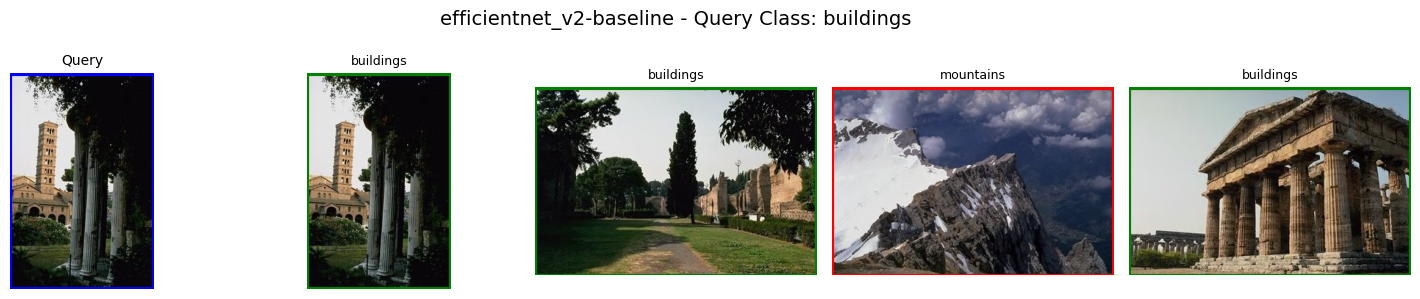


Menampilkan Top-K untuk efficientnet_v2-pretrained:


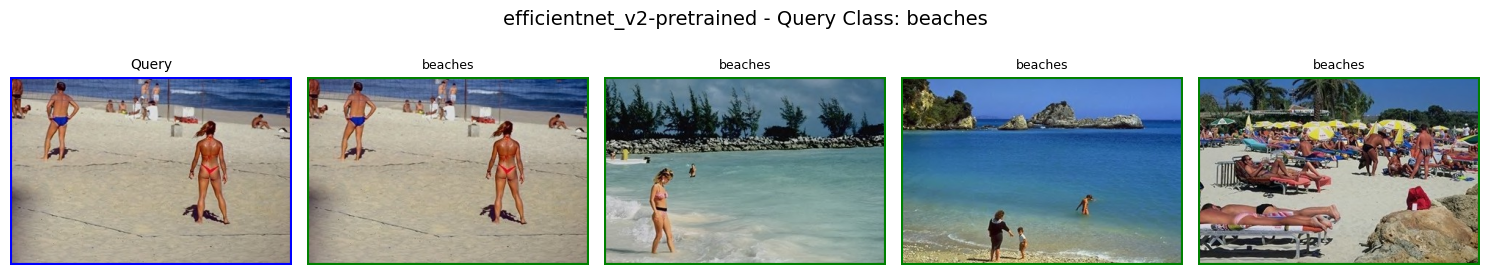


Menampilkan Top-K untuk convnext-baseline:


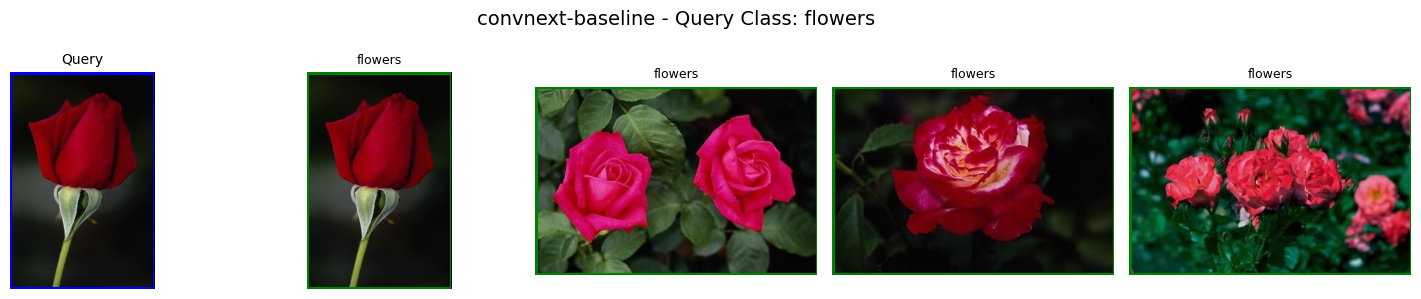


Menampilkan Top-K untuk convnext-pretrained:


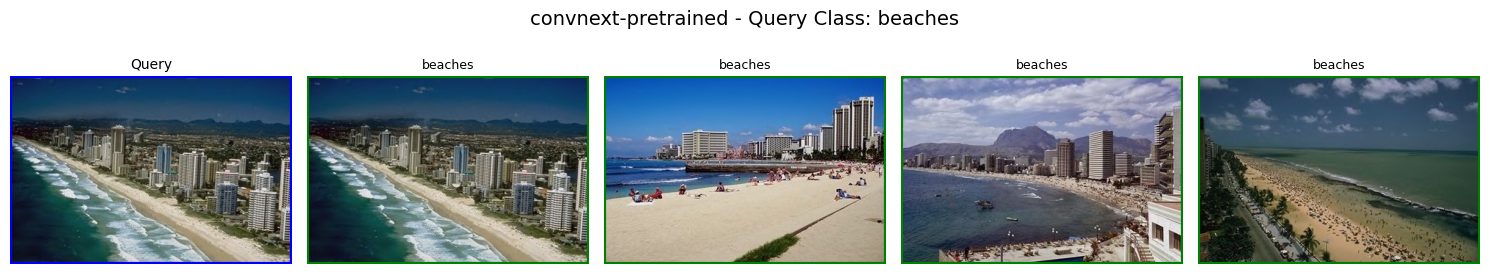


Menampilkan Top-K untuk resnet50-baseline:


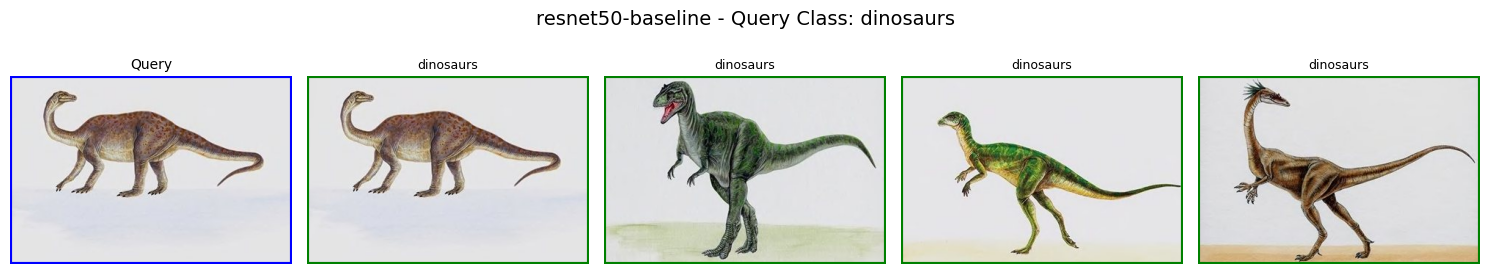


Menampilkan Top-K untuk resnet50-pretrained:


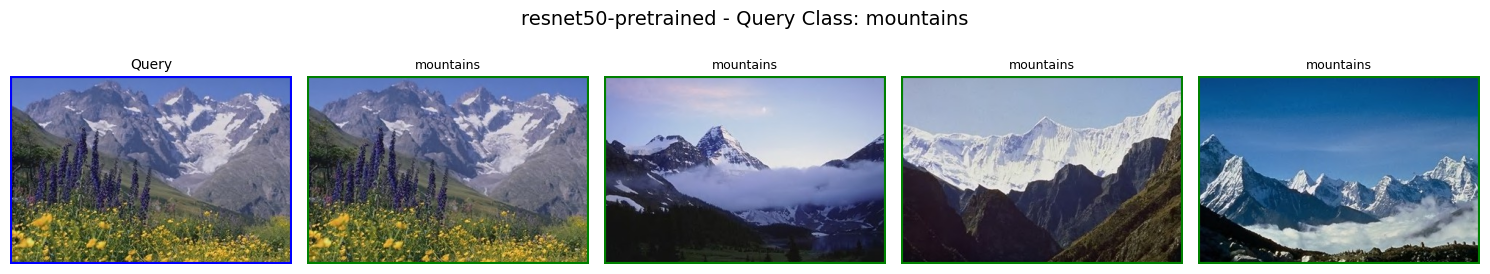

In [24]:
for m_name, m_types in features_dict.items():
    for t_name in ["baseline", "pretrained"]:  # hanya baseline & pretrained
        feats = m_types[t_name]
        model_label = f"{m_name}-{t_name}"

        print(f"\nMenampilkan Top-K untuk {model_label}:")
        query_idx = random.randint(0, len(labels) - 1)

        show_topk_cbir(
            features=feats,
            labels=labels,
            img_paths=img_paths,
            top_k=4,
            model_name=model_label,
            query_idx=query_idx
        )

### Tahap 4: Model Evaluation

In [ ]:
# Fungsi konversi tensor ke numpy
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

# Fungsi ukur inference speed batch-wise
def measure_inference_speed_batch(model, img_paths, transform, device='cuda', batch_size=32):
    model.eval()
    times = []

    with torch.no_grad():
        for i in tqdm(range(0, len(img_paths), batch_size), desc="Processing batches"):
            batch_imgs = []
            for img_path in img_paths[i:i+batch_size]:
                img = Image.open(img_path).convert('RGB')
                batch_imgs.append(transform(img))
            batch_tensor = torch.stack(batch_imgs).to(device)

            if device == 'cuda':
                torch.cuda.synchronize()
            start = time.time()

            if hasattr(model, "forward_features"):
                # ConvNeXt
                x = model.forward_features(batch_tensor)
                x = torch.nn.functional.adaptive_avg_pool2d(x, 1)
            elif "resnet" in model.__class__.__name__.lower():
                # ResNet manual forward
                x = model.conv1(batch_tensor)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                x = model.layer4(x)
                x = model.avgpool(x)
            else:
                # EfficientNet
                x = model.features(batch_tensor)
                x = torch.nn.functional.adaptive_avg_pool2d(x, 1)

            _ = torch.flatten(x, 1)

            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            times.append((end - start)/len(batch_imgs))  # rata-rata per gambar

    return np.mean(times)

# Fungsi embedding metrics tetap sama
def measure_embedding_metrics(features, labels):
    features = to_numpy(features)
    start = time.time()
    sims = cosine_similarity(features, features)
    search_time = time.time() - start

    classes = list(set(labels))
    inter_dists, intra_dists = [], []

    for i, cls_i in enumerate(classes):
        idx_i = [k for k, l in enumerate(labels) if l == cls_i]
        for j, cls_j in enumerate(classes):
            if i >= j:
                continue
            idx_j = [k for k, l in enumerate(labels) if l == cls_j]
            inter_dists.append(np.mean(sims[np.ix_(idx_i, idx_j)]))

    for cls in classes:
        idx = [k for k, l in enumerate(labels) if l == cls]
        intra_dists.append(np.mean(sims[np.ix_(idx, idx)]))

    return search_time, np.mean(inter_dists), np.mean(intra_dists)

# Hitung metrics semua model × tipe
results = []

for m_name, m_types in models_dict.items():
    for t_name in ["baseline", "pretrained"]:
        print(f"Processing {m_name}-{t_name} ...")
        model = m_types[t_name]
        feats = features_dict[m_name][t_name]

        # 1. inference speed batch
        avg_inf_time = measure_inference_speed_batch(model, img_paths, transform, device=device, batch_size=32) # type: ignore

        # 2. embedding metrics
        search_time, inter, intra = measure_embedding_metrics(feats, labels)

        results.append({
            "Model": f"{m_name}-{t_name}",
            "Inference speed (s/img)": avg_inf_time,
            "Embedding search time (s)": search_time,
            "Inter-class dist": inter,
            "Intra-class dist": intra
        })

df_metrics = pd.DataFrame(results)
display(df_metrics)

Model  Inference speed (s/img)  \
0    efficientnet_v2-baseline                 0.047521   
1  efficientnet_v2-pretrained                 0.016737   
2           convnext-baseline                 0.015051   
3         convnext-pretrained                 0.007576   
4           resnet50-baseline                 0.007200   
5         resnet50-pretrained                 0.010091   

   Embedding search time (s)  Inter-class dist  Intra-class dist  
0                   0.018689          0.798924          0.867538  
1                   0.002628          0.042177          0.513482  
2                   0.014614          0.042504          0.553366  
3                   0.005160          0.321577          0.656107  
4                   0.025655          0.999283          0.999448  
5                   0.005714          0.156273          0.561026

In [26]:
df_table = pd.DataFrame()
df_table['Class'] = sorted(list(set(labels)))

# Tambahkan kolom R & P untuk baseline & pretrained
for m_name, m_types in eval_results.items():
    for t_name in ["baseline", "pretrained"]:  # hanya baseline & pretrained
        df = m_types[t_name]
        col_prefix = f"{m_name}-{t_name}"
        df_table[f"{col_prefix} R"] = df['R'].astype(float)
        df_table[f"{col_prefix} P"] = df['P'].astype(float)

# Hitung mean per kolom
mean_values = {}
for col in df_table.columns[1:]:
    mean_values[col] = df_table[col].mean()

mean_row = {'Class': 'Mean'}
mean_row.update(mean_values)

# Tambahkan baris Mean
df_table = pd.concat([df_table, pd.DataFrame([mean_row])], ignore_index=True)

# Format angka
for col in df_table.columns[1:]:
    df_table[col] = df_table[col].map("{:.4f}".format)

display(df_table)

Class efficientnet_v2-baseline R efficientnet_v2-baseline P  \
0    africans                     0.0364                     0.3640   
1     beaches                     0.0405                     0.4050   
2   buildings                     0.0351                     0.3510   
3       buses                     0.0597                     0.5970   
4   dinosaurs                     0.1000                     1.0000   
5   elephants                     0.0434                     0.4340   
6     flowers                     0.0895                     0.8950   
7        food                     0.0521                     0.5210   
8      horses                     0.0570                     0.5700   
9   mountains                     0.0389                     0.3890   
10       Mean                     0.0553                     0.5526   

   efficientnet_v2-pretrained R efficientnet_v2-pretrained P  \
0                        0.0857                       0.8570   
1                        0.0968                       0.9680   
2                        0.0958                       0.9580   
3                        0.1000                       1.0000   
4                        0.1000                       1.0000   
5                        0.1000                       1.0000   
6                        0.0999                       0.9990   
7                        0.0978                       0.9780   
8                        0.0999                       0.9990   
9                        0.0991                       0.9910   
10                       0.0975                       0.9750   

   convnext-baseline R convnext-baseline P convnext-pretrained R  \
0               0.0168              0.1680                0.0824   
1               0.0442              0.4420                0.0972   
2               0.0215              0.2150                0.0964   
3               0.0253              0.2530                0.1000   
4               0.0999              0.9990                0.1000   
5               0.0403              0.4030                0.1000   
6               0.0792              0.7920                0.0999   
7               0.0450              0.4500                0.0975   
8               0.0904              0.9040                0.1000   
9               0.0516              0.5160                0.0986   
10              0.0514              0.5142                0.0972   

   convnext-pretrained P resnet50-baseline R resnet50-baseline P  \
0                 0.8240              0.0385              0.3850   
1                 0.9720              0.0269              0.2690   
2                 0.9640              0.0288              0.2880   
3                 1.0000              0.0529              0.5290   
4                 1.0000              0.1000              1.0000   
5                 1.0000              0.0475              0.4750   
6                 0.9990              0.0844              0.8440   
7                 0.9750              0.0598              0.5980   
8                 1.0000              0.0699              0.6990   
9                 0.9860              0.0398              0.3980   
10                0.9720              0.0548              0.5485   

   resnet50-pretrained R resnet50-pretrained P  
0                 0.0917                0.9170  
1                 0.0925                0.9250  
2                 0.0957                0.9570  
3                 0.1000                1.0000  
4                 0.1000                1.0000  
5                 0.1000                1.0000  
6                 0.1000                1.0000  
7                 0.0991                0.9910  
8                 0.1000                1.0000  
9                 0.0980                0.9800  
10                0.0977                0.9770

efficientnet_v2-baseline Recall@10 Precision@10 selesai
efficientnet_v2-baseline Recall@20 Precision@20 selesai
efficientnet_v2-baseline Recall@30 Precision@30 selesai
efficientnet_v2-baseline Recall@40 Precision@40 selesai
efficientnet_v2-baseline Recall@50 Precision@50 selesai
efficientnet_v2-baseline Recall@60 Precision@60 selesai
efficientnet_v2-baseline Recall@70 Precision@70 selesai
efficientnet_v2-baseline Recall@80 Precision@80 selesai
efficientnet_v2-baseline Recall@90 Precision@90 selesai
efficientnet_v2-baseline Recall@100 Precision@100 selesai
efficientnet_v2-pretrained Recall@10 Precision@10 selesai
efficientnet_v2-pretrained Recall@20 Precision@20 selesai
efficientnet_v2-pretrained Recall@30 Precision@30 selesai
efficientnet_v2-pretrained Recall@40 Precision@40 selesai
efficientnet_v2-pretrained Recall@50 Precision@50 selesai
efficientnet_v2-pretrained Recall@60 Precision@60 selesai
efficientnet_v2-pretrained Recall@70 Precision@70 selesai
efficientnet_v2-pretrained Recal

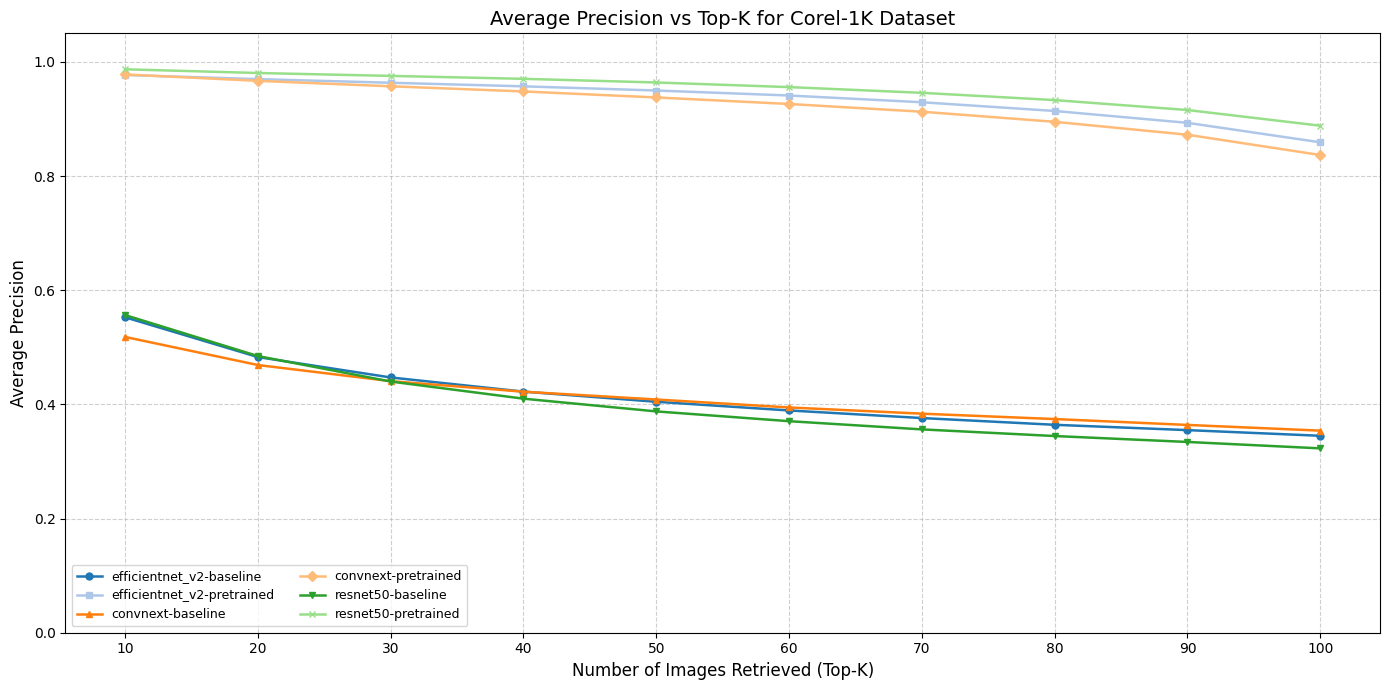

In [27]:
def average_precision_vs_topk(features_dict, labels, top_k_max=100):
    import matplotlib.pyplot as plt

    top_ks = list(range(10, top_k_max + 1, 10))
    avg_prec = {}

    # Loop model dan tipe (hanya baseline & pretrained)
    for m_name, m_types in features_dict.items():
        for t_name in ["baseline", "pretrained"]:
            feats = m_types[t_name]
            key = f"{m_name}-{t_name}"
            avg_prec[key] = []

            for top_k in top_ks:
                df = evaluate_recall_precision(feats, labels, top_k=top_k, model_type=key)
                df['P'] = df['P'].astype(float)
                avg_prec[key].append(df['P'].mean())

    # Visualisasi
    plt.figure(figsize=(14, 7))
    model_keys = list(avg_prec.keys())
    num_lines = len(model_keys)
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % 20) for i in range(num_lines)]
    markers = ['o', 's', '^', 'D', 'v', 'x', '*', 'P']

    for i, key in enumerate(model_keys):
        jitter = i * 0.002
        y_vals = [v + jitter for v in avg_prec[key]]

        plt.plot(
            top_ks,
            y_vals,
            marker=markers[i % len(markers)],
            color=colors[i],
            linestyle='-',
            linewidth=1.8,
            markersize=5,
            label=key
        )

    plt.xlabel("Number of Images Retrieved (Top-K)", fontsize=12)
    plt.ylabel("Average Precision", fontsize=12)
    plt.title("Average Precision vs Top-K for Corel-1K Dataset", fontsize=14)
    plt.xticks(top_ks)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=9, ncol=2)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


# Panggil fungsi untuk baseline & pretrained
average_precision_vs_topk(features_dict, labels, top_k_max=100)

In [28]:
print("Available models:", features_dict.keys())

for model in features_dict:
    print(model, "->", features_dict[model].keys())

Available models: dict_keys(['efficientnet_v2', 'convnext', 'resnet50'])
efficientnet_v2 -> dict_keys(['baseline', 'pretrained'])
convnext -> dict_keys(['baseline', 'pretrained'])
resnet50 -> dict_keys(['baseline', 'pretrained'])


## Dataset: GHIM-10K

### Tahap 1: Model Initialization

In [38]:
# CONTEXT & TARGET ENCODER DEFINITIONS
class ContextEncoder(nn.Module):
    def __init__(self, backbone, backbone_output_dim, embedding_dim):
        super().__init__()
        self.backbone = backbone
        self.proj = nn.Linear(backbone_output_dim, embedding_dim)

    def forward(self, x):
        if hasattr(self.backbone, "forward_features"):
            h = self.backbone.forward_features(x)
            h = torch.nn.functional.adaptive_avg_pool2d(h, 1)
            h = torch.flatten(h, 1)
        elif "resnet" in self.backbone.__class__.__name__.lower():
            h = self.backbone.conv1(x)
            h = self.backbone.bn1(h)
            h = self.backbone.relu(h)
            h = self.backbone.maxpool(h)
            h = self.backbone.layer1(h)
            h = self.backbone.layer2(h)
            h = self.backbone.layer3(h)
            h = self.backbone.layer4(h)
            h = self.backbone.avgpool(h)
            h = torch.flatten(h, 1)
        else:
            h = self.backbone.features(x)
            h = torch.nn.functional.adaptive_avg_pool2d(h, 1)
            h = torch.flatten(h, 1)
        z_c = self.proj(h)
        return z_c

class TargetEncoder(nn.Module):
    def __init__(self, backbone, backbone_output_dim, embedding_dim):
        super().__init__()
        self.backbone = backbone
        self.proj = nn.Linear(backbone_output_dim, embedding_dim)

    def forward(self, x):
        h = self.backbone(x)
        z_t = self.proj(h)
        return z_t

class Predictor(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward(self, z_c):
        return self.net(z_c)


# BASELINE MODELS
efficientnet_v2_base = models.efficientnet_v2_s(weights=None).to(device).eval()
resnet50_base = models.resnet50(weights=None).to(device).eval()
convnext_base = models.convnext_tiny(weights=None).to(device).eval()

# PRETRAINED MODELS (backbone only)
efficientnet_v2_pre = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT).to(device).eval()
resnet50_pre = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device).eval()
convnext_pre = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT).to(device).eval()

# JOINT-EMBEDDING CONTEXT ENCODERS
context_encoders = {
    "efficientnet_v2": ContextEncoder(backbone=efficientnet_v2_pre, backbone_output_dim=1280, embedding_dim=256).to(device).eval(),
    "resnet50": ContextEncoder(backbone=resnet50_pre, backbone_output_dim=2048, embedding_dim=256).to(device).eval(),
    "convnext": ContextEncoder(backbone=convnext_pre, backbone_output_dim=768, embedding_dim=256).to(device).eval()
}

### Tahap 2: Feature Extraction (JOINT-EMBEDDING MODELS INITIALIZATION)

In [39]:
# Fungsi ekstraksi fitur untuk baseline
def extract_features(model, img_t):
    with torch.no_grad():
        name = model.__class__.__name__.lower()

        if hasattr(model, "forward_features"):
            x = model.forward_features(img_t)
            x = torch.nn.functional.adaptive_avg_pool2d(x, 1)
        elif "resnet" in name:
            x = model.conv1(img_t)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
        else:
            x = model.features(img_t)
            x = torch.nn.functional.adaptive_avg_pool2d(x, 1)

        x = torch.flatten(x, 1)

    return x.squeeze().cpu().numpy()


# Load dataset paths
img_paths = []
labels = []
for cls in os.listdir(data_dir_GHIM):
    cls_path = os.path.join(data_dir_GHIM, cls)
    for f in os.listdir(cls_path):
        img_paths.append(os.path.join(cls_path, f))
        labels.append(cls)


# Model dictionary
models_dict = {
    "efficientnet_v2": {"baseline": efficientnet_v2_base, "pretrained": efficientnet_v2_pre},
    "convnext": {"baseline": convnext_base, "pretrained": convnext_pre},
    "resnet50": {"baseline": resnet50_base, "pretrained": resnet50_pre}
}

# Pindahkan ke device
for m in models_dict:
    for t in models_dict[m]:
        models_dict[m][t] = models_dict[m][t].to(device)
        models_dict[m][t].eval()

# Dictionary untuk menyimpan fitur
features_dict = {m: {t: [] for t in ["baseline", "pretrained"]} for m in models_dict}


# Ekstraksi fitur
for path in tqdm(img_paths, desc="Extracting Features"):
    img = Image.open(path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device) # pyright: ignore[reportAttributeAccessIssue]

    for m_name in models_dict:
        for t_name in models_dict[m_name]:
            if t_name == "pretrained":
                # Pakai joint-embedding context encoder
                with torch.no_grad():
                    feat = context_encoders[m_name](img_t)
                    feat = feat.squeeze().cpu().numpy()
            else:
                # Pakai backbone biasa (baseline)
                feat = extract_features(models_dict[m_name][t_name], img_t)

            features_dict[m_name][t_name].append(feat)

# Normalisasi L2
for m_name in features_dict:
    for t_name in features_dict[m_name]:
        arr = np.array(features_dict[m_name][t_name])
        features_dict[m_name][t_name] = normalize(arr).tolist()

# Contoh akses fitur
efficientnet_pre = np.array(features_dict["efficientnet_v2"]["pretrained"])
convnext_base = np.array(features_dict["convnext"]["baseline"])
resnet_base = np.array(features_dict["resnet50"]["baseline"])

Extracting Features: 100%|██████████| 10016/10016 [24:56<00:00,  6.69it/s] 


### Tahap 3: Image Retrieval & Similarity Matching

In [ ]:
# Fungsi retrieval
def retrieve(query_feat: np.ndarray, all_feats: np.ndarray, top_k=10):
    sims = cosine_similarity(query_feat[None, :], all_feats)[0]
    idxs = np.argsort(sims)[::-1][:top_k]
    return idxs

# Evaluasi Recall@K dan Precision@K
def evaluate_recall_precision(features, labels, top_k=10, model_type='pretrained'):
    features = np.asarray(features, dtype=float)

    classes = sorted(list(set(labels)))
    results = []

    for cls in classes:
        class_idx = [i for i, l in enumerate(labels) if l == cls]
        R_list, P_list = [], []

        for q in class_idx:
            retrieved_idx = retrieve(features[q], features, top_k)
            retrieved_labels = [labels[i] for i in retrieved_idx]

            R = retrieved_labels.count(cls) / len(class_idx)
            P = retrieved_labels.count(cls) / top_k

            R_list.append(R)
            P_list.append(P)

        results.append([cls, np.mean(R_list), np.mean(P_list)])

    df = pd.DataFrame(results, columns=['Class', 'R', 'P'])

    mean_row = {
        'Class': 'Mean',
        'R': df['R'].mean(),
        'P': df['P'].mean()
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)

    df['R'] = df['R'].astype(float).map("{:.4f}".format)
    df['P'] = df['P'].astype(float).map("{:.4f}".format)

    print(f"{model_type} Recall@{top_k} Precision@{top_k} selesai")
    return df


eval_results = {}

for m_name, m_types in features_dict.items():
    eval_results[m_name] = {}
    for t_name in ["baseline", "pretrained"]:
        feats = m_types[t_name]
        df = evaluate_recall_precision(
            feats,
            labels,
            top_k=10,
            model_type=f"{m_name}-{t_name}"
        )
        eval_results[m_name][t_name] = df

In [ ]:
def to_numpy(features):
    import numpy as np

    # Jika features berupa list
    if isinstance(features, list):
        # Jika list berisi tuple (embedding, path)
        if len(features) > 0 and isinstance(features[0], tuple):
            return np.array([f[0] for f in features], dtype=np.float32)
        else:
            return np.array(features, dtype=np.float32)
    
    return features

In [ ]:
def show_topk_cbir(features, labels, img_paths, top_k=4, model_name="Model", query_idx=None):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image

    # Pastikan features berupa numpy array
    features = to_numpy(features)

    # Pilih query secara acak jika tidak diberikan
    if query_idx is None:
        import random
        query_idx = random.randint(0, len(labels) - 1)

    query_class = labels[query_idx]
    retrieved_idx = retrieve(features[query_idx], features, top_k)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{model_name} - Query Class: {query_class}", fontsize=14)

    # Tampilkan gambar query
    query_img = Image.open(img_paths[query_idx]).convert('RGB')
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query", fontsize=10)
    plt.gca().add_patch(patches.Rectangle(
        (0, 0), query_img.width, query_img.height,
        edgecolor='blue', fill=False, linewidth=3
    ))

    # Tampilkan top-k hasil retrieval
    for i, idx in enumerate(retrieved_idx):
        img = Image.open(img_paths[idx]).convert('RGB')
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')

        # Warna kotak: hijau jika benar, merah jika salah
        color = 'green' if labels[idx] == query_class else 'red'
        plt.gca().add_patch(patches.Rectangle(
            (0, 0), img.width, img.height,
            edgecolor=color, fill=False, linewidth=3
        ))
        plt.title(labels[idx], fontsize=9)

    plt.tight_layout()
    plt.show()


Menampilkan Top-K untuk efficientnet_v2-baseline:


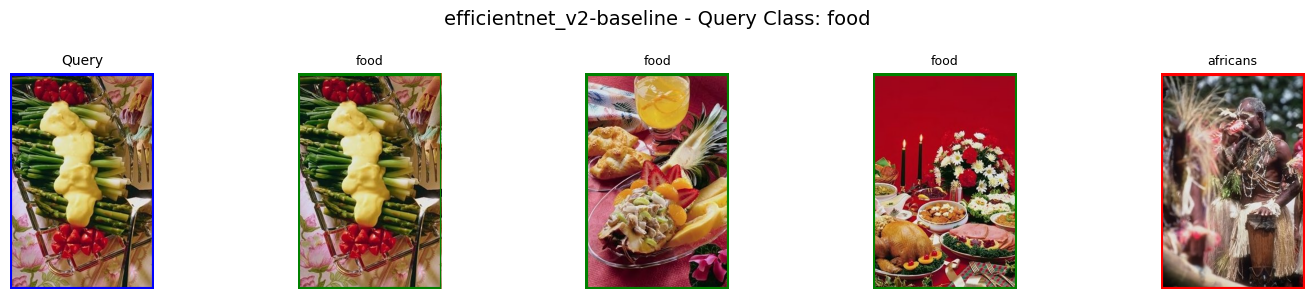


Menampilkan Top-K untuk efficientnet_v2-pretrained:


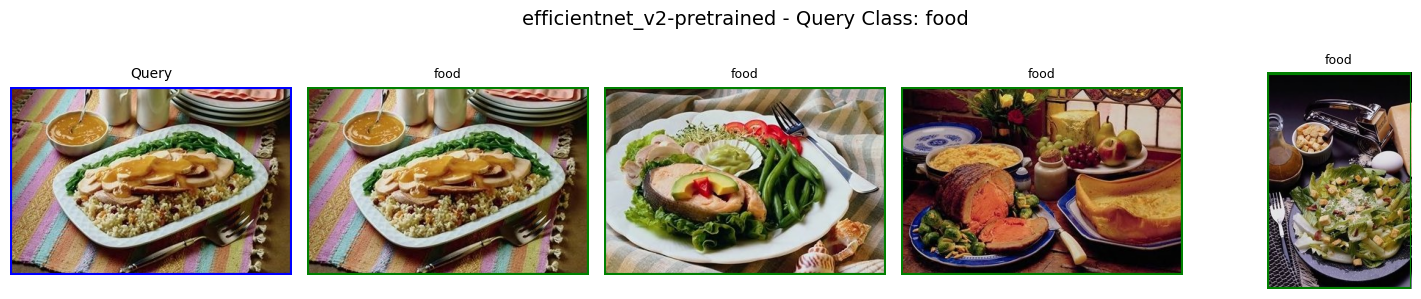


Menampilkan Top-K untuk convnext-baseline:


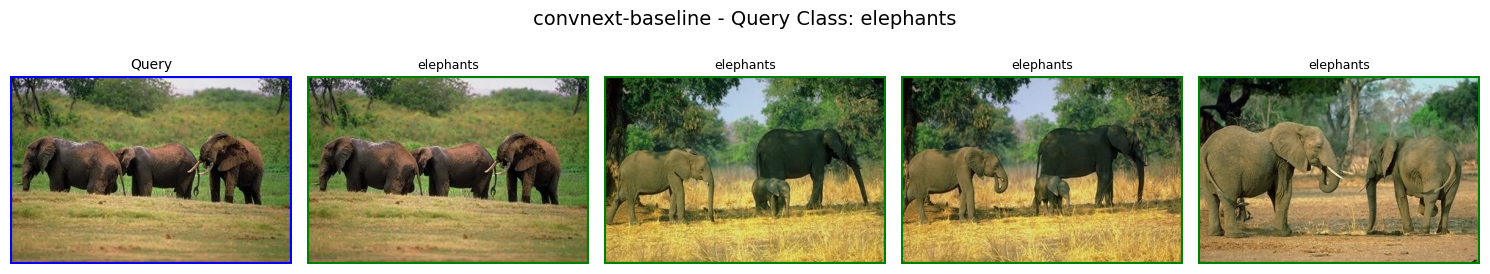


Menampilkan Top-K untuk convnext-pretrained:


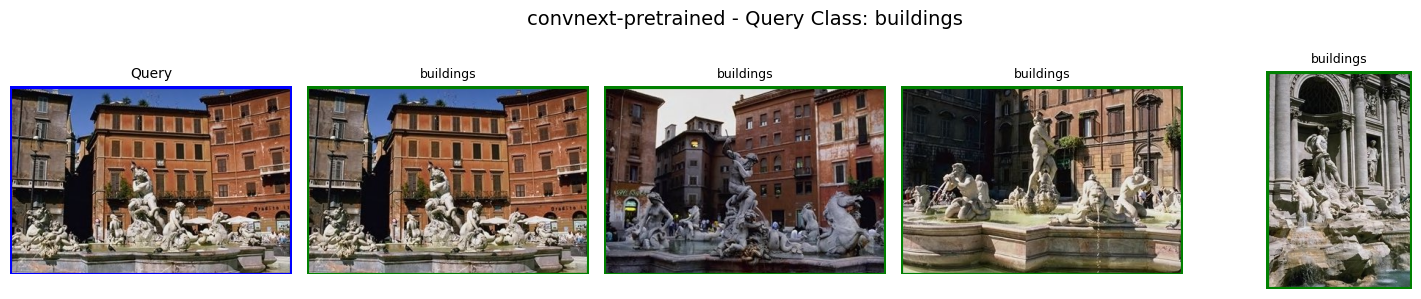


Menampilkan Top-K untuk resnet50-baseline:


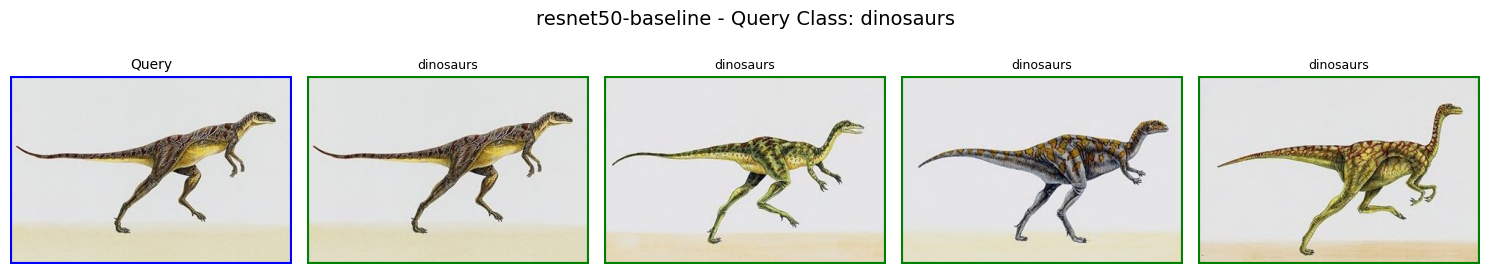


Menampilkan Top-K untuk resnet50-pretrained:


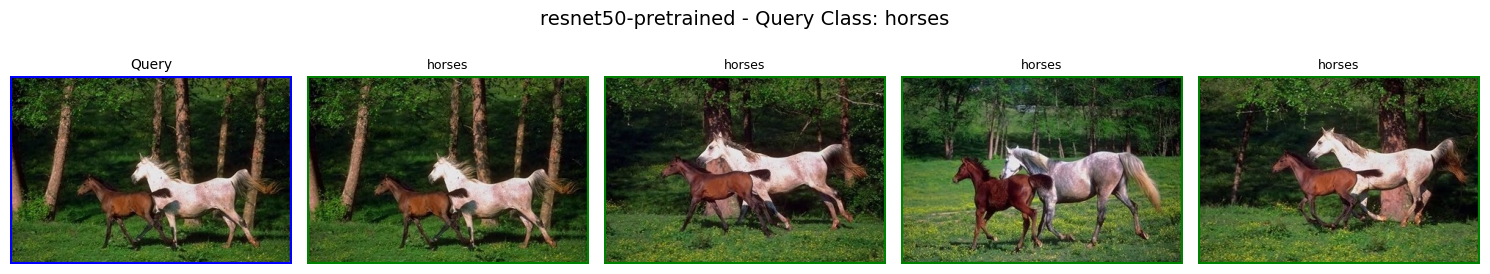

In [ ]:
for m_name, m_types in features_dict.items():
    for t_name in ["baseline", "pretrained"]:  # hanya baseline & pretrained
        feats = m_types[t_name]
        model_label = f"{m_name}-{t_name}"

        print(f"\nMenampilkan Top-K untuk {model_label}:")
        query_idx = random.randint(0, len(labels) - 1)

        show_topk_cbir(
            features=feats,
            labels=labels,
            img_paths=img_paths,
            top_k=4,
            model_name=model_label,
            query_idx=query_idx
        )

### Tahap 4: Model Evaluation

In [ ]:
# Fungsi konversi tensor ke numpy
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

# Fungsi ukur inference speed batch-wise
def measure_inference_speed_batch(model, img_paths, transform, device='cuda', batch_size=32):
    model.eval()
    times = []

    with torch.no_grad():
        for i in tqdm(range(0, len(img_paths), batch_size), desc="Processing batches"):
            batch_imgs = []
            for img_path in img_paths[i:i+batch_size]:
                img = Image.open(img_path).convert('RGB')
                batch_imgs.append(transform(img))
            batch_tensor = torch.stack(batch_imgs).to(device)

            if device == 'cuda':
                torch.cuda.synchronize()
            start = time.time()

            if hasattr(model, "forward_features"):
                # ConvNeXt
                x = model.forward_features(batch_tensor)
                x = torch.nn.functional.adaptive_avg_pool2d(x, 1)
            elif "resnet" in model.__class__.__name__.lower():
                # ResNet manual forward
                x = model.conv1(batch_tensor)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)
                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                x = model.layer4(x)
                x = model.avgpool(x)
            else:
                # EfficientNet
                x = model.features(batch_tensor)
                x = torch.nn.functional.adaptive_avg_pool2d(x, 1)

            _ = torch.flatten(x, 1)

            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            times.append((end - start)/len(batch_imgs))  # rata-rata per gambar

    return np.mean(times)

# Fungsi embedding metrics tetap sama
def measure_embedding_metrics(features, labels):
    features = to_numpy(features)
    start = time.time()
    sims = cosine_similarity(features, features)
    search_time = time.time() - start

    classes = list(set(labels))
    inter_dists, intra_dists = [], []

    for i, cls_i in enumerate(classes):
        idx_i = [k for k, l in enumerate(labels) if l == cls_i]
        for j, cls_j in enumerate(classes):
            if i >= j:
                continue
            idx_j = [k for k, l in enumerate(labels) if l == cls_j]
            inter_dists.append(np.mean(sims[np.ix_(idx_i, idx_j)]))

    for cls in classes:
        idx = [k for k, l in enumerate(labels) if l == cls]
        intra_dists.append(np.mean(sims[np.ix_(idx, idx)]))

    return search_time, np.mean(inter_dists), np.mean(intra_dists)

# Hitung metrics semua model × tipe
results = []

for m_name, m_types in models_dict.items():
    for t_name in ["baseline", "pretrained"]:
        print(f"Processing {m_name}-{t_name} ...")
        model = m_types[t_name]
        feats = features_dict[m_name][t_name]

        # 1. inference speed batch
        avg_inf_time = measure_inference_speed_batch(model, img_paths, transform, device=device, batch_size=32) # type: ignore

        # 2. embedding metrics
        search_time, inter, intra = measure_embedding_metrics(feats, labels)

        results.append({
            "Model": f"{m_name}-{t_name}",
            "Inference speed (s/img)": avg_inf_time,
            "Embedding search time (s)": search_time,
            "Inter-class dist": inter,
            "Intra-class dist": intra
        })

df_metrics = pd.DataFrame(results)
display(df_metrics)

Model  Inference speed (s/img)  \
0    efficientnet_v2-baseline                 0.032423   
1  efficientnet_v2-pretrained                 0.021237   
2           convnext-baseline                 0.033092   
3         convnext-pretrained                 0.006000   
4           resnet50-baseline                 0.015046   
5         resnet50-pretrained                 0.013038   

   Embedding search time (s)  Inter-class dist  Intra-class dist  
0                   0.008506          0.784136          0.881456  
1                   0.008021          0.032196          0.527693  
2                   0.010016          0.033922          0.557457  
3                   0.002995          0.334956          0.666785  
4                   0.025449          0.998965          0.999233  
5                   0.002502          0.139570          0.562417

In [ ]:
df_table = pd.DataFrame()
df_table['Class'] = sorted(list(set(labels)))

# Tambahkan kolom R & P untuk baseline & pretrained
for m_name, m_types in eval_results.items():
    for t_name in ["baseline", "pretrained"]:  # hanya baseline & pretrained
        df = m_types[t_name]
        col_prefix = f"{m_name}-{t_name}"
        df_table[f"{col_prefix} R"] = df['R'].astype(float)
        df_table[f"{col_prefix} P"] = df['P'].astype(float)

# Hitung mean per kolom
mean_values = {}
for col in df_table.columns[1:]:
    mean_values[col] = df_table[col].mean()

mean_row = {'Class': 'Mean'}
mean_row.update(mean_values)

# Tambahkan baris Mean
df_table = pd.concat([df_table, pd.DataFrame([mean_row])], ignore_index=True)

# Format angka
for col in df_table.columns[1:]:
    df_table[col] = df_table[col].map("{:.4f}".format)

display(df_table)

Class efficientnet_v2-baseline R efficientnet_v2-baseline P  \
0    africans                     0.0405                     0.4050   
1     beaches                     0.0504                     0.5040   
2   buildings                     0.0382                     0.3820   
3       buses                     0.0563                     0.5630   
4   dinosaurs                     0.0998                     0.9980   
5   elephants                     0.0460                     0.4600   
6     flowers                     0.0792                     0.7920   
7        food                     0.0541                     0.5410   
8      horses                     0.0711                     0.7110   
9   mountains                     0.0446                     0.4460   
10       Mean                     0.0580                     0.5802   

   efficientnet_v2-pretrained R efficientnet_v2-pretrained P  \
0                        0.0884                       0.8840   
1                        0.0965                       0.9650   
2                        0.0954                       0.9540   
3                        0.1000                       1.0000   
4                        0.1000                       1.0000   
5                        0.1000                       1.0000   
6                        0.1000                       1.0000   
7                        0.0991                       0.9910   
8                        0.1000                       1.0000   
9                        0.0997                       0.9970   
10                       0.0979                       0.9791   

   convnext-baseline R convnext-baseline P convnext-pretrained R  \
0               0.0165              0.1650                0.0853   
1               0.0446              0.4460                0.0976   
2               0.0213              0.2130                0.0965   
3               0.0272              0.2720                0.1000   
4               0.0998              0.9980                0.1000   
5               0.0417              0.4170                0.1000   
6               0.0769              0.7690                0.1000   
7               0.0470              0.4700                0.0977   
8               0.0904              0.9040                0.1000   
9               0.0539              0.5390                0.0983   
10              0.0519              0.5193                0.0975   

   convnext-pretrained P resnet50-baseline R resnet50-baseline P  \
0                 0.8530              0.0418              0.4180   
1                 0.9760              0.0248              0.2480   
2                 0.9650              0.0333              0.3330   
3                 1.0000              0.0550              0.5500   
4                 1.0000              0.1000              1.0000   
5                 1.0000              0.0561              0.5610   
6                 1.0000              0.0801              0.8010   
7                 0.9770              0.0532              0.5320   
8                 1.0000              0.0761              0.7610   
9                 0.9830              0.0360              0.3600   
10                0.9754              0.0556              0.5564   

   resnet50-pretrained R resnet50-pretrained P  
0                 0.0905                0.9050  
1                 0.0946                0.9460  
2                 0.0937                0.9370  
3                 0.1000                1.0000  
4                 0.1000                1.0000  
5                 0.1000                1.0000  
6                 0.1000                1.0000  
7                 0.0989                0.9890  
8                 0.1000                1.0000  
9                 0.0971                0.9710  
10                0.0975                0.9748

In [ ]:
def average_precision_vs_topk(features_dict, labels, top_k_max=100):
    import matplotlib.pyplot as plt

    top_ks = list(range(10, top_k_max + 1, 10))
    avg_prec = {}

    # Loop model dan tipe (hanya baseline & pretrained)
    for m_name, m_types in features_dict.items():
        for t_name in ["baseline", "pretrained"]:
            feats = m_types[t_name]
            key = f"{m_name}-{t_name}"
            avg_prec[key] = []

            for top_k in top_ks:
                df = evaluate_recall_precision(feats, labels, top_k=top_k, model_type=key)
                df['P'] = df['P'].astype(float)
                avg_prec[key].append(df['P'].mean())

    # Visualisasi
    plt.figure(figsize=(14, 7))
    model_keys = list(avg_prec.keys())
    num_lines = len(model_keys)
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % 20) for i in range(num_lines)]
    markers = ['o', 's', '^', 'D', 'v', 'x', '*', 'P']

    for i, key in enumerate(model_keys):
        jitter = i * 0.002
        y_vals = [v + jitter for v in avg_prec[key]]

        plt.plot(
            top_ks,
            y_vals,
            marker=markers[i % len(markers)],
            color=colors[i],
            linestyle='-',
            linewidth=1.8,
            markersize=5,
            label=key
        )

    plt.xlabel("Number of Images Retrieved (Top-K)", fontsize=12)
    plt.ylabel("Average Precision", fontsize=12)
    plt.title("Average Precision vs Top-K for Corel-1K Dataset", fontsize=14)
    plt.xticks(top_ks)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=9, ncol=2)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()


# Panggil fungsi untuk baseline & pretrained
average_precision_vs_topk(features_dict, labels, top_k_max=100)

efficientnet_v2-baseline Recall@10 Precision@10 selesai
efficientnet_v2-baseline Recall@20 Precision@20 selesai
efficientnet_v2-baseline Recall@30 Precision@30 selesai
efficientnet_v2-baseline Recall@40 Precision@40 selesai
efficientnet_v2-baseline Recall@50 Precision@50 selesai
efficientnet_v2-baseline Recall@60 Precision@60 selesai
efficientnet_v2-baseline Recall@70 Precision@70 selesai
efficientnet_v2-baseline Recall@80 Precision@80 selesai
efficientnet_v2-baseline Recall@90 Precision@90 selesai


KeyboardInterrupt: 

In [ ]:
print("Available models:", features_dict.keys())

for model in features_dict:
    print(model, "->", features_dict[model].keys())